In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
key = jax.random.PRNGKey(0)

mpl.rc('font', family='serif', size=16)
jax.config.update("jax_enable_x64", True)

In [2]:
import tinygp
import smolgp

In [3]:
from scipy.interpolate import make_smoothing_spline

def get_true_qsm(true_kernel, tmin=0, tmax=1000, dt=1):
    t = jnp.arange(tmin, tmax, dt)
    true_gp = tinygp.GaussianProcess(true_kernel, t)
    # gp.sample adds small random noise for numerical stability
    y_sample = true_gp.sample(key=jax.random.PRNGKey(32)) 
    f = make_smoothing_spline(t, y_sample, lam=dt/6)
    return t, f

In [4]:
offset = jnp.sqrt(jnp.finfo(jnp.array([0.])).eps)

## Kernel testing

### Exp

In [5]:
# sigma = 2.1
# scale = 83.3

# kssm = smolgp.kernels.Exp(scale=scale, sigma=sigma)
# kqsm = tinygp.kernels.quasisep.Exp(scale=scale, sigma=sigma)

### Matern-3/2

In [6]:
# sigma = 2.1
# scale = 83.3

# kssm = smolgp.kernels.Matern32(scale=scale, sigma=sigma)
# kqsm = tinygp.kernels.quasisep.Matern32(scale=scale, sigma=sigma)

### Matern-5/2

In [7]:
# sigma = 2.1
# scale = 83.3

# kssm = smolgp.kernels.Matern52(scale=scale, sigma=sigma)
# kqsm = tinygp.kernels.quasisep.Matern52(scale=scale, sigma=sigma)

### SHO

In [8]:
sigma = 2.1
omega = 2*jnp.pi/83.3
quality = 5.3 # underdamped
# quality = 0.5 # critically damped
# quality = 0.1 # overdamped

kssm = smolgp.kernels.SHO(omega, quality, sigma)
kqsm = tinygp.kernels.quasisep.SHO(omega, quality, sigma)

### Cosine

In [9]:
# sigma = 2.1
# scale = 83.3

# kssm = smolgp.kernels.Cosine(scale=scale, sigma=sigma)
# kqsm = tinygp.kernels.quasisep.Cosine(scale=scale, sigma=sigma)

### ExpSineSquared

In [10]:
ell = 1.164 # 0.7
gamma = 2/ell**2
print(f'{ell}  {gamma:.2f}')
period = 163.3
sigma = 1.

kssm = smolgp.kernels.ExpSineSquared(gamma=gamma, period=period, sigma=sigma)
kqsm = tinygp.kernels.ExpSineSquared(gamma=gamma, scale=period)
kssm.order

1.164  1.48


4

In [11]:
# # Confirm "Wrapper" doesn't get decomposed
# from smolgp.kernels.base import extract_leaf_kernels
# len(extract_leaf_kernels(kssm)) == 1

## Quasiperiodic

In [12]:
# ell = 1.164
# gamma = 2/ell**2
# print(f'{ell}  {gamma:.2f}')
# period = 163.3
# sigma = 1.

# scale = 23.6 # for ExpSquared
# eta = jnp.sqrt(1/(2*gamma))

# # kssm = smolgp.kernels.ExpSineSquared(gamma=gamma, period=period, sigma=sigma)
# # # kqsm = tinygp.kernels.Quasiperiodic(gamma=gamma, scale=period)
# # kssm.order

### test integrated versions (TODO: make dedicated function for those, as they need exposure times)

In [13]:
# sigma = 2.1
# scale = 83.3

# kssm = smolgp.kernels.IntegratedCosine(scale=scale, sigma=sigma)
# kqsm = tinygp.kernels.quasisep.Cosine(scale=scale, sigma=sigma)

# PSD

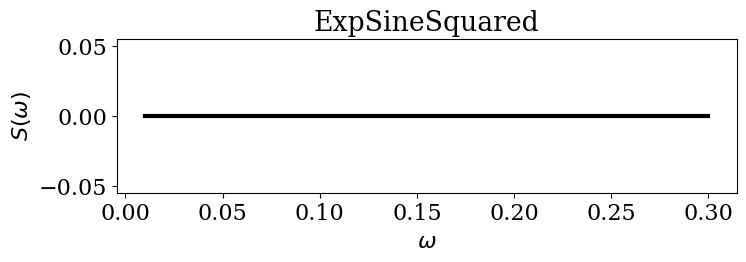

In [14]:
w = jnp.linspace(0.01, 0.3, 1000)
S = kssm.psd(w)

fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(w, S, color='k', lw=3)
ax.set(title=kssm.name)
ax.set(xlabel=r'$\omega$', ylabel=r'$S(\omega)$');

## Covariance function

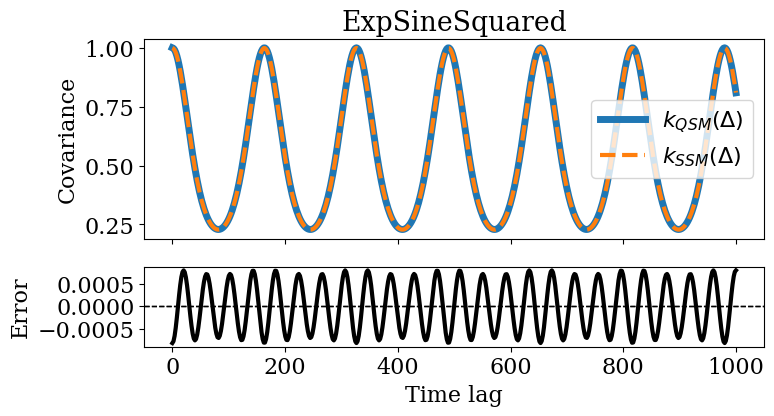

In [15]:
dts = jnp.linspace(0, 1000, 500)
zeros = jnp.zeros_like(dts)

cov_qsm = kqsm(zeros, dts)[0,:]
cov_ssm = kssm(zeros, dts)[0,:]
res_cov = cov_ssm - cov_qsm

fig, (ax, rax) = plt.subplots(2, 1, figsize=(8,4), sharex=True, gridspec_kw={'height_ratios': [3, 1.2]})
ax.set_title(f'{kqsm.__class__.__name__}')
ax.plot(dts, cov_qsm, label=r'$k_{QSM}(\Delta)$', lw=5, color='C0')
ax.plot(dts, cov_ssm, label=r'$k_{SSM}(\Delta)$', lw=3, color='C1', ls='--')
ax.set_ylabel('Covariance'); ax.legend()
eps = jnp.spacing(cov_qsm)
rax.plot(dts, res_cov, lw=3, color='k')
rax.set_ylabel('Error'); rax.set_xlabel('Time lag')
eps = np.abs(np.spacing(cov_qsm))
epsmax = eps.max()
rax.axhline(epsmax,  color='k', ls='--', lw=1)
rax.axhline(-epsmax, color='k', ls='--', lw=1);
# rax.set_yscale('symlog', linthresh=epsmax)

## Test likelihood/condition/predict
TODO: Put below into test function

In [16]:
## True process
t_true, f = get_true_qsm(kqsm, tmin=0, tmax=1000, dt=1)
y_true = f(t_true)

## Mock data
t_train  = jnp.sort(jax.random.uniform(key, (50,), minval=0, maxval=1000))
yerr = 0.3 * jnp.ones_like(t_train)
y_train = f(t_train) + yerr * jax.random.normal(key, t_train.shape)

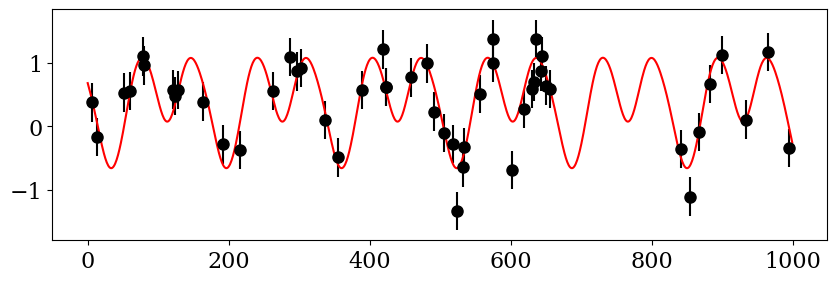

In [17]:
plt.figure(figsize=(10, 3))
plt.errorbar(t_train, y_train, yerr=yerr, fmt="ok", 
             markeredgecolor='k', markersize=8, capsize=0)
plt.plot(t_true, y_true, "-r", label="True process")

In [18]:
gp_ssm = smolgp.GaussianProcess(kernel=kssm, X=t_train, diag=yerr**2)
gp_qsm = tinygp.GaussianProcess(kernel=kqsm, X=t_train, diag=yerr**2)

In [19]:
# do_assert = True
do_assert = False

llh_threshold = 1e-12
cond_threshold = 1e-9
pred_threshold = 1e-9

print(f'Testing {kssm.name}\n')

## Likelihoods
print('Log-likelihoods:')
llh_ssm = gp_ssm.log_probability(y_train)
llh_qsm = gp_qsm.log_probability(y_train)
llh_diff = llh_ssm - llh_qsm
print(f"   smolgp: {llh_ssm:f}")
print(f"   tinygp: {llh_qsm:f}")
print(f"   Difference: {llh_diff:.3e}")
if do_assert:
    assert jnp.abs(llh_diff) < llh_threshold, "Log-likelihoods do not match!"

## Conditioning
print('\nConditioning GPs on data...')
llh_qsm2, condGP_qsm = gp_qsm.condition(y_train, t_train)
llh_ssm2, condGP_ssm = gp_ssm.condition(y_train)
if do_assert:
    assert llh_qsm2==llh_qsm, 'tinygp: Condition returned different llh than log_probability!'
    assert llh_ssm2==llh_ssm, 'smolgp: Condition returned different llh than log_probability!'
mean_diff = condGP_qsm.loc - condGP_ssm.loc
var_diff  = (condGP_qsm.variance-offset) - condGP_ssm.variance
print(f'   Mean max abs diff: {jnp.max(jnp.abs(mean_diff)):.3e}')
print(f'   Variance max abs diff: {jnp.max(jnp.abs(var_diff)):.3e}')
# assert jnp.max(jnp.abs(mean_diff)) < cond_threshold, "Conditioned means do not match!"
# assert jnp.max(jnp.abs(var_diff)) < cond_threshold, "Conditioned variances do not match!"

## Predictions
print('\nPredictions at new points:')
t_test = jnp.linspace(0, 1000, 1000)
mu_qsm, var_qsm = gp_qsm.predict(y_train, t_test, return_var=True)
mu_ssm, var_ssm = condGP_ssm.predict(t_test, return_var=True)
pred_mean_diff = mu_qsm - mu_ssm
pred_var_diff  = (var_qsm - offset) - var_ssm
print(f'   Mean max abs diff: {jnp.max(jnp.abs(pred_mean_diff)):.3e}')
print(f'   Variance max abs diff: {jnp.max(jnp.abs(pred_var_diff)):.3e}')
if do_assert:
    assert jnp.max(jnp.abs(pred_mean_diff)) < pred_threshold, "Predicted means do not match!"
    assert jnp.max(jnp.abs(pred_var_diff)) < pred_threshold, "Predicted variances do not match!"

if do_assert:
    print('\nMachine precision!')

Testing ExpSineSquared

Log-likelihoods:
   smolgp: -23.057054
   tinygp: -23.113743
   Difference: 5.669e-02

Conditioning GPs on data...
   Mean max abs diff: 1.573e-02
   Variance max abs diff: 1.541e-03

Predictions at new points:
   Mean max abs diff: 1.583e-02
   Variance max abs diff: 1.748e-03


## Plot

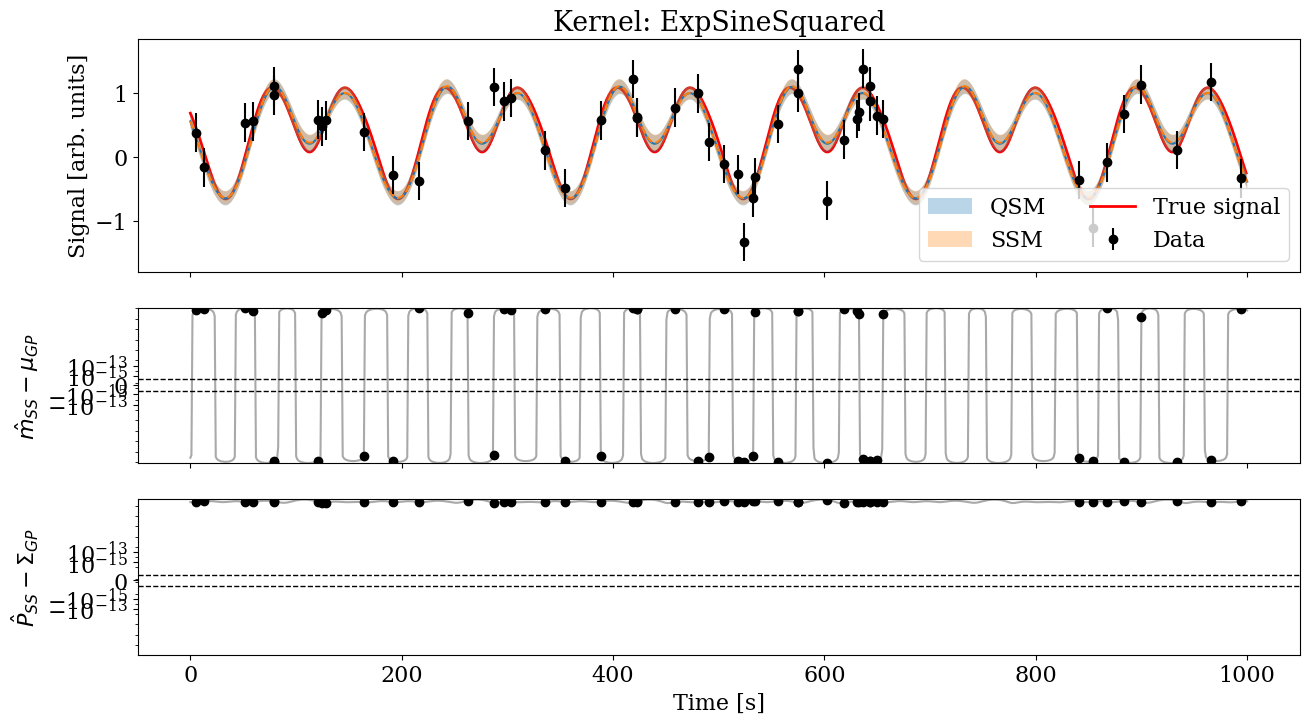

In [20]:
fig, (ax, rax, rrax) = plt.subplots(3,1, figsize=(15,8), sharex=True,
                                    gridspec_kw={'height_ratios':[1.5,1,1]})

## Predictions
ax.plot(t_test, mu_qsm)
ax.plot(t_test, mu_ssm, ls='--')
ax.fill_between(t_test, mu_qsm-jnp.sqrt(var_qsm), mu_qsm+jnp.sqrt(var_qsm), alpha=0.3, label='QSM')
ax.fill_between(t_test, mu_ssm-jnp.sqrt(var_ssm), mu_ssm+jnp.sqrt(var_ssm), alpha=0.3, label='SSM')
ax.set(ylabel='Signal [arb. units]', title=f'Kernel: {kssm.name}')

## Data and true signal
ax.plot(t_true, y_true, label='True signal', color='r', lw=2, zorder=-10)
ax.errorbar(t_train, y_train, yerr, fmt='o', color='k', label='Data', alpha=1)
ax.legend(ncol=2)

## Mean residuals
rax.scatter(t_train, mean_diff, color='k', zorder=100)
rax.plot(t_test, pred_mean_diff, color='darkgrey')
eps = np.abs(np.spacing(mu_ssm))
epsmax = eps.max()
rax.axhline(epsmax,  color='k', ls='--', lw=1)
rax.axhline(-epsmax, color='k', ls='--', lw=1)
rax.set(ylabel=r'$\hat{m}_{SS}- \mu_{GP}$')
rax.set_yscale('symlog', linthresh=epsmax)
yticks = jnp.arange(-15, -12+1, 2).astype(jnp.float64)
yticks = jnp.hstack((-10**yticks[::-1], 0, 10**yticks))
rax.set_yticks(yticks)

## Var residuals
rrax.scatter(t_train, var_diff, color='k', zorder=100)
rrax.plot(t_test, pred_var_diff, color='darkgrey')
eps = np.abs(np.spacing(var_ssm))
epsmax = eps.max()
rrax.axhline(epsmax,  color='k', ls='--', lw=1)
rrax.axhline(-epsmax, color='k', ls='--', lw=1)
rrax.set(ylabel=r'$\hat{P}_{SS}- \Sigma_{GP}$')
rrax.set_yscale('symlog', linthresh=epsmax)
yticks = jnp.arange(-15, -12+1, 2).astype(jnp.float64)
yticks = jnp.hstack((-10**yticks[::-1], 0, 10**yticks))
rrax.set_yticks(yticks)
rrax.set_xlabel('Time [s]');